# Download a chunk of an ITS_LIVE datacube, invert for average velocities between each satellite observation

requires datacube_tools.py in directory with notebook.  
https://github.com/nasa-jpl/its_live/blob/main/notebooks/datacube_tools.py

In [2]:
import xarray
import numpy as np
import matplotlib.pyplot as plt
import itsinv_old
import zarr

## Invert for velocity timeseries

In [9]:
xy = (-3310000, 257700)
solu, res, xsub, mask = itsinv_old.grid_inversion(xy, half_dist=8000, 
                                                  lt=1e-4, 
                                                  lx=10, 
                                                  sat_filt=["1A"], 
                                                  start_date="2017-10-01", 
                                                  stop_date="2018-10-01", 
                                                  pbar=True, 
                                                  return_data=True)

original xy (-3310000, 257700) 3413 maps to datacube (-3310000, 257700) EPSG:3413
subset and load at 528.42 seconds


100%|████████████████████████████████████| 34322/34322 [04:40<00:00, 122.22it/s]


In [10]:
# Convert decimal year to datetime64
s_in_year = (60*60*24*365)
solu_datetime = [None]*len(solu)
for i in range(len(solu)):
    whole_year = int(solu[i])
    frac_year = solu[i] - whole_year
    solu_datetime[i] = np.datetime64(str(whole_year))
    solu_datetime[i] += np.timedelta64(int(frac_year*s_in_year), "s")
    
# Make components into speed
v = np.sqrt(res["vx"]**2 + res["vy"]**2)

## Quick plots to see if reasonable

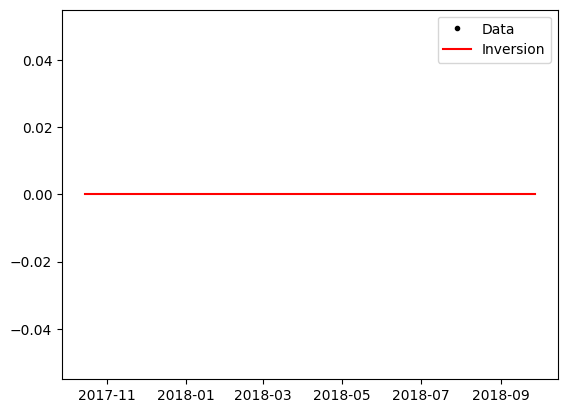

In [11]:
# mid-dates for data
md = xsub.acquisition_date_img1 + ((xsub.acquisition_date_img2 - xsub.acquisition_date_img1)/2)
v_data = np.sqrt(xsub.vx**2 + xsub.vy**2)

plt.plot(md[mask], v_data[mask][:,1,1], "k.", label="Data")
plt.plot(solu_datetime, v[:,1,1], "r-", label="Inversion")
plt.legend()

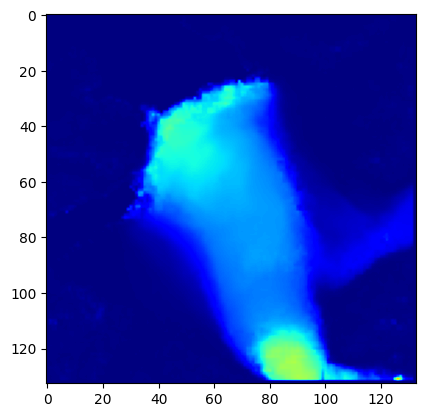

In [12]:
plt.imshow(np.mean(v, axis=0), vmin=0, vmax=6000, cmap="jet")
#plt.imshow(np.mean(v, axis=0), cmap="jet")

## Package and save results

In [14]:
xres = xarray.Dataset(
    data_vars = dict(
        speed=(["time", "y", "x"], v),
    ),
    coords = dict(
        x = xsub.x,
        y = xsub.y,
        time = solu_datetime,
    ),
    attrs = dict(
        projection = xsub.projection,
        GDAL_AREA_OR_POINT = xsub.GDAL_AREA_OR_POINT,
    ))

xres.to_netcdf("hubbard_2018.nc")
#xres.to_netcdf("Jakobshavn_2019.nc")
#xres.to_netcdf("columbia_2019.nc")

/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_12155/3459697234.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xres = xarray.Dataset(
